## importando a base de dados nescessaria

In [3]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import optuna
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)


import warnings
warnings.filterwarnings('ignore')

### Funções

In [5]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [6]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [7]:
data = pd.read_parquet(bucket_uri)

In [8]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [9]:
data['id'].nunique()

30490

In [10]:
data['item_id'].nunique()

3049

In [11]:
data['dept_id'].nunique()

7

In [12]:
data['cat_id'].nunique()

3

In [13]:
data['store_id'].nunique()

10

In [14]:
data['state_id'].nunique()

3

In [15]:
data['date'] = pd.to_datetime(data['date'])

In [16]:
data = data.set_index('date')

## Previsão produtos (id)✅

In [17]:
df_produto = data.groupby(['id']).resample('MS')['value'].sum()

Pegando os 100 melhores produtos

In [18]:
top_100_produtos = df_produto.groupby('id').sum().nlargest(100).index

In [19]:
df_produto = df_produto[df_produto.index.get_level_values('id').isin(top_100_produtos)]

In [20]:
df_produto.to_frame()

value
id                              date             
FOODS_1_218_TX_2_evaluation     2011-01-01     10
                                2011-02-01    121
                                2011-03-01    106
                                2011-04-01    119
                                2011-05-01     87
...                                           ...
HOUSEHOLD_1_459_CA_3_evaluation 2016-01-01    516
                                2016-02-01    496
                                2016-03-01    618
                                2016-04-01    758
                                2016-05-01    333

[6500 rows x 1 columns]

In [21]:
df_produto_reset_index = df_produto.reset_index()

In [22]:
df_nixtla = pd.DataFrame({
    'unique_id': df_produto_reset_index['id'],
    'ds': df_produto_reset_index['date'],
    'y': df_produto_reset_index['value']
})

In [23]:
df_nixtla.head(3)

,unique_id,ds,y
0,FOODS_1_218_TX_2_evaluation,2011-01-01,10
1,FOODS_1_218_TX_2_evaluation,2011-02-01,121
2,FOODS_1_218_TX_2_evaluation,2011-03-01,106


In [24]:
df_nixtla['ds'] = pd.to_datetime(df_nixtla['ds'])

In [25]:
df_nixtla['unique_id'].value_counts().sum()

6500

In [26]:
df_test = df_nixtla.groupby('unique_id').tail(6)
df_train = df_nixtla.drop(df_test.index)

In [27]:
df_train.shape, df_test.shape

((5900, 3), (600, 3))

In [28]:
models = {
    "Lgbm": AutoLightGBM(),
    "ARF": AutoRandomForest(),
    "ALR": AutoLinearRegression(),
    "AXGB": AutoXGBoost(),
    "ridge": AutoRidge()
}

In [29]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [30]:
auto_mlf.fit(
    df=df_train,
    n_windows=2,
    h=12,
    num_samples=10,
    optimize_kwargs={'timeout': 600},
    fitted=True
)

[I 2024-07-04 20:51:47,964] A new study created in memory with name: no-name-91d09764-21fe-418d-bc97-92bb6114e6b3
[I 2024-07-04 20:51:48,357] Trial 0 finished with value: 0.21708439411117514 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 0 with value: 0.21708439411117514.
[I 2024-07-04 20:51:50,910] Trial 1 finished with value: 0.32473093271255493 and parameters: {'n_estimators': 920, 'lambda_l1': 0.15574964948467418, 'lambda_l2': 0.00014233583723829364, 'num_leaves': 722, 'feature_fraction': 0.5591372129344666, 'bagging_fraction': 0.819960510663762, 'objective': 'l2', 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.21708439411117

AutoMLForecast(models={'Lgbm': AutoModel(model=LGBMRegressor), 'ARF': AutoModel(model=RandomForestRegressor), 'ALR': AutoModel(model=LinearRegression), 'AXGB': AutoModel(model=XGBRegressor), 'ridge': AutoModel(model=Ridge)})

In [31]:
predict = auto_mlf.predict(6)
predict.head()

,unique_id,ds,Lgbm,ARF,ALR,AXGB,ridge
0,FOODS_1_218_TX_2_evaluation,2015-12-01,468.566543,493.122207,475.108459,525.763977,507.373169
1,FOODS_1_218_TX_2_evaluation,2016-01-01,424.556731,598.350166,478.911987,504.934814,584.394897
2,FOODS_1_218_TX_2_evaluation,2016-02-01,418.495290,620.903526,488.930145,479.145813,614.655151
3,FOODS_1_218_TX_2_evaluation,2016-03-01,518.720103,616.460524,497.803802,532.248108,642.915649
4,FOODS_1_218_TX_2_evaluation,2016-04-01,578.452318,616.008911,505.883942,587.444763,649.113647


In [32]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

### Analisando os resultados dos modelos

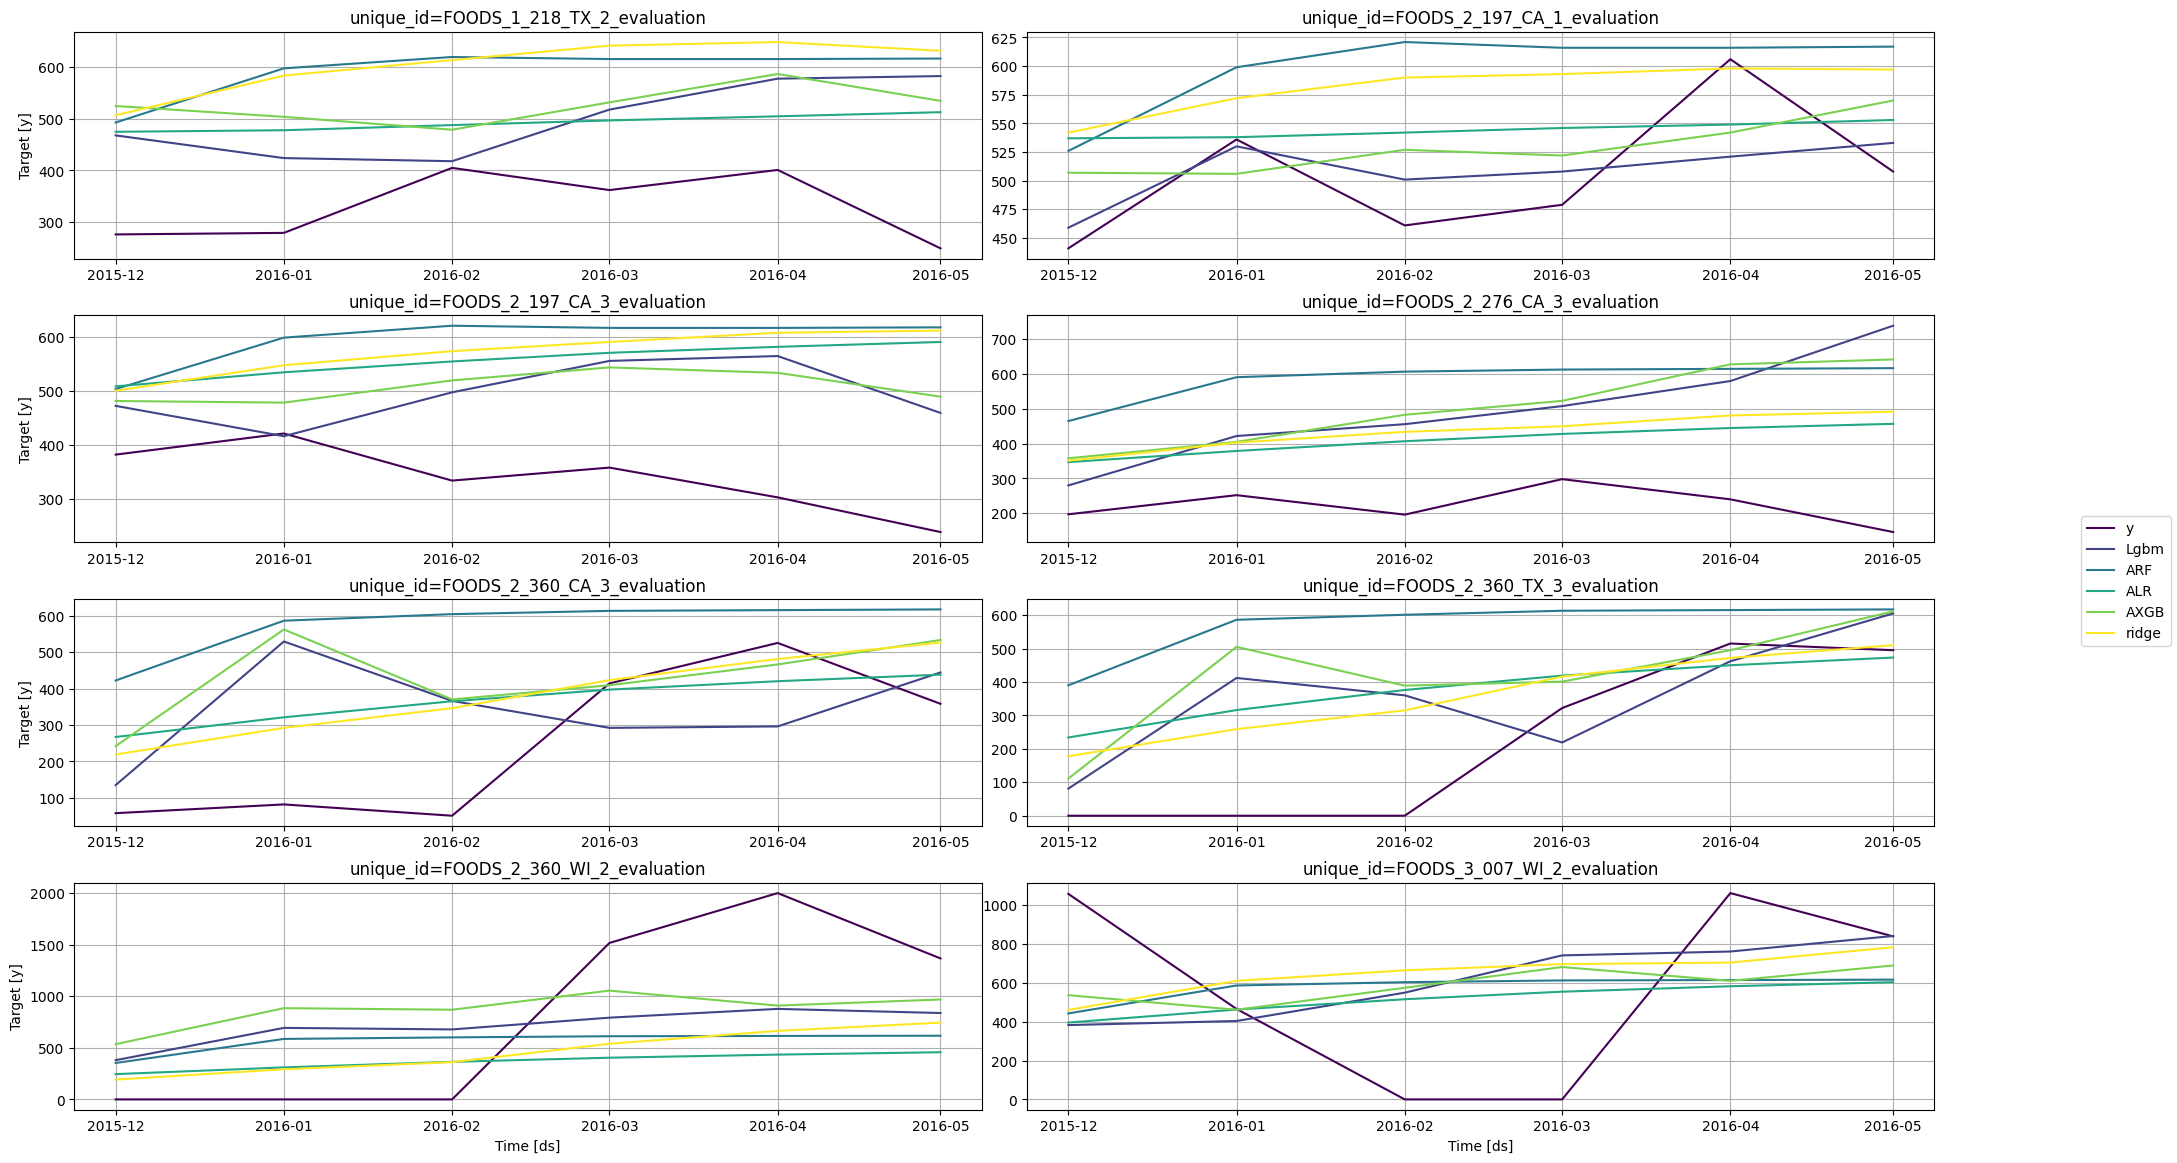

In [33]:
plot_series(df_test, predict, plot_random=False)

In [34]:
previsao_full = df_test.merge(predict, how='right', on=['unique_id', 'ds'])

In [35]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], previsao_full[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------Lgbm-----------------
Mean Absolute Error: 244.4
Mean absolute percentage error: 4.912676593523316e+16
Root mean squared error: 365.0622595302524
R2: 0.554938479789016


------------------ARF-----------------
Mean Absolute Error: 247.995
Mean absolute percentage error: 6.440898067077704e+16
Root mean squared error: 372.5374321237174
R2: 0.5365253284363543


------------------ALR-----------------
Mean Absolute Error: 244.09
Mean absolute percentage error: 4.745292807372713e+16
Root mean squared error: 382.7959465128473
R2: 0.5106486028195212


------------------AXGB-----------------
Mean Absolute Error: 236.75833333333333
Mean absolute percentage error: 5.895211912227979e+16
Root mean squared error: 374.41769678617845
R2: 0.5318350387195054


------------------ridge-----------------
Mean Absolute Error: 235.00333333333333
Mean absolute percentage error: 4.783573404205362e+16
Root mean squared error: 359.0607608748135
R2: 0.5694515146810337




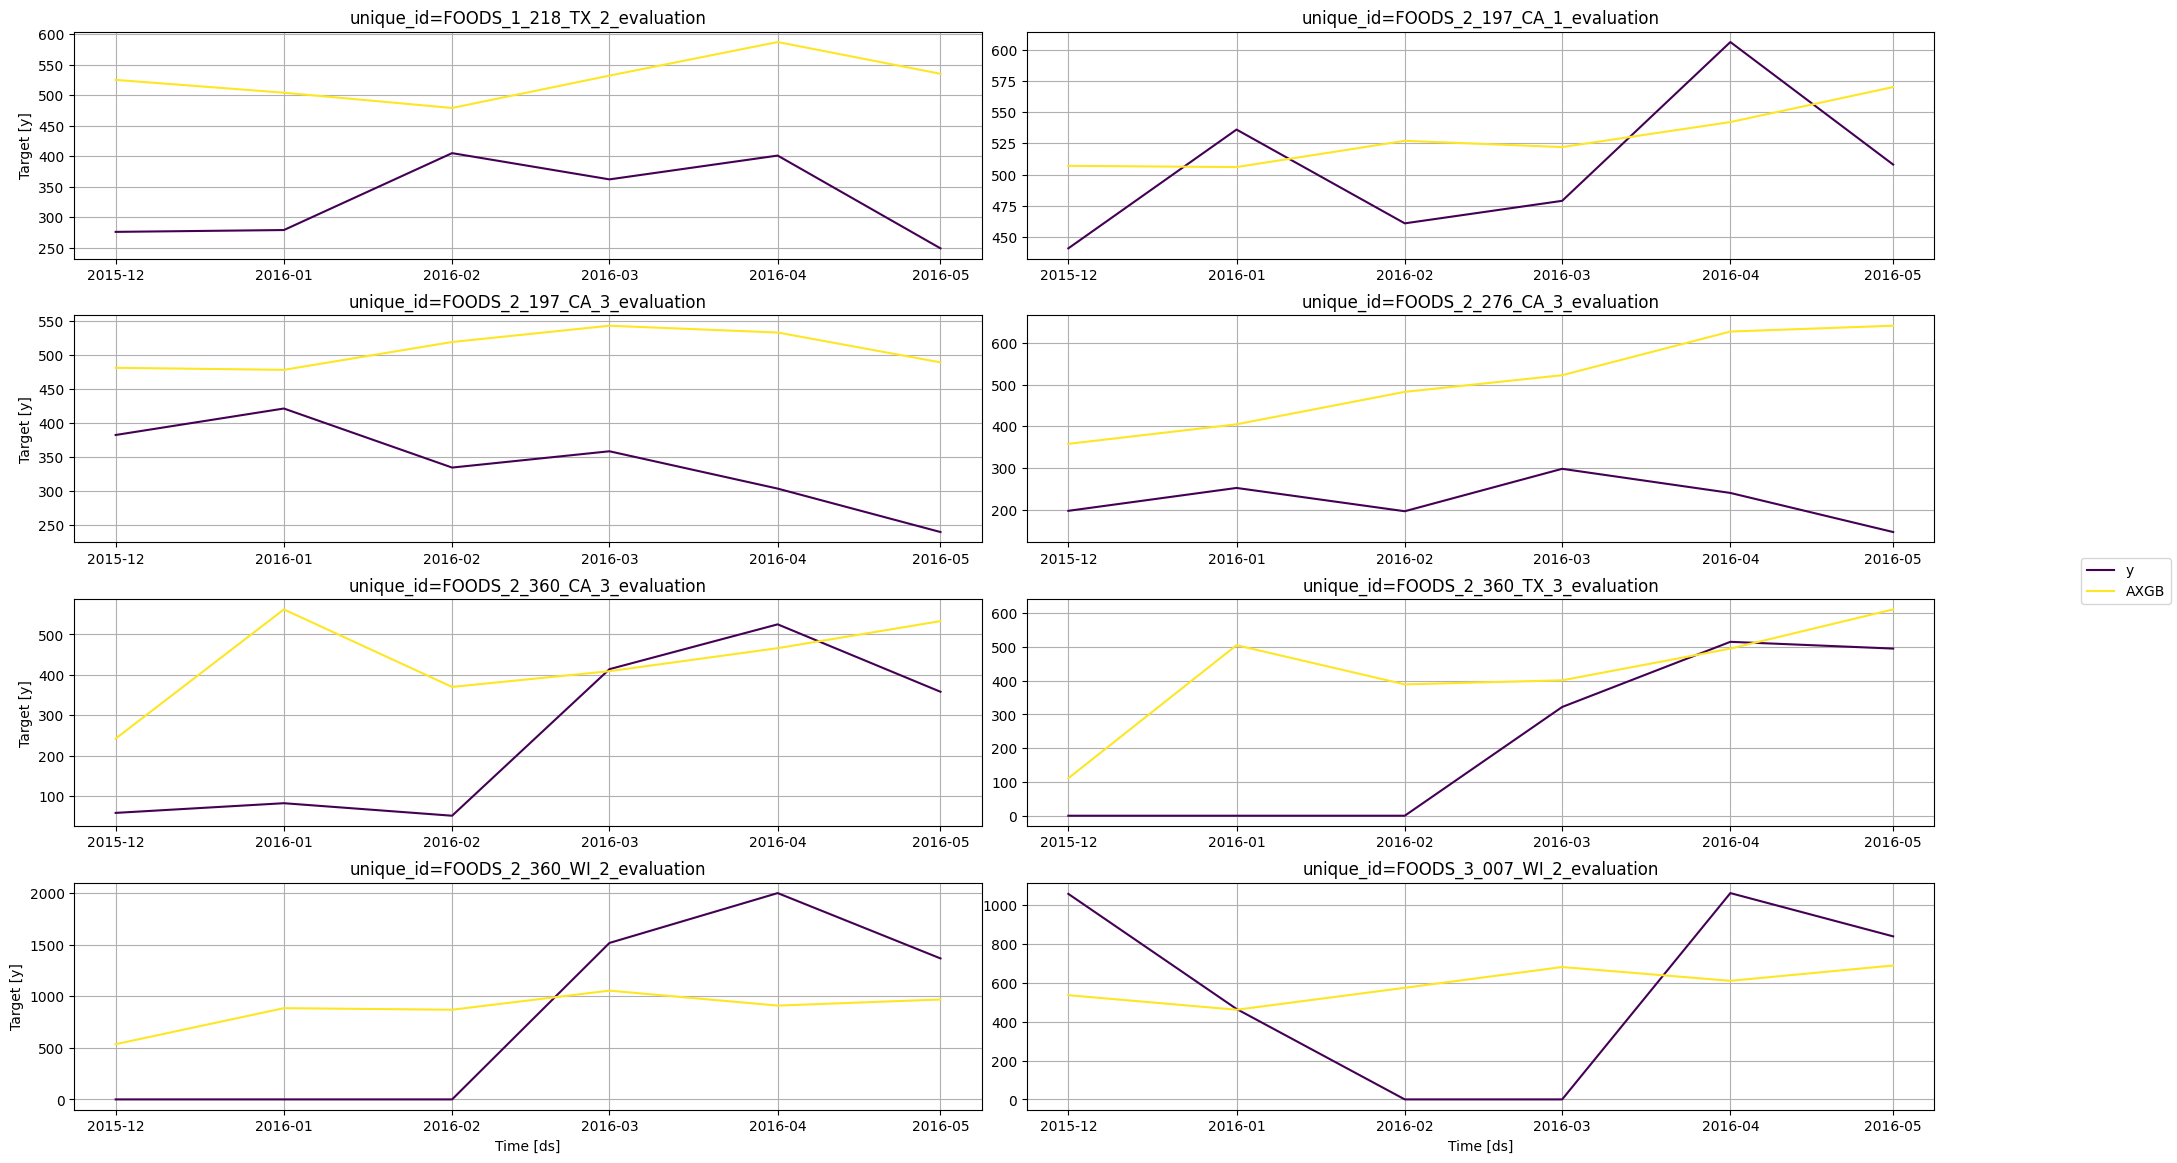

In [36]:
plot_series(df_test, predict[['unique_id', 'ds', 'AXGB']], plot_random=False)

In [37]:
metrics = [mae, rmse, mape]

In [38]:
previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()

,unique_id,ds,y,Lgbm,ARF,ALR,AXGB,ridge
0,FOODS_1_218_TX_2_evaluation,2015-12-01,276,468,493,475,525,507
1,FOODS_1_218_TX_2_evaluation,2016-01-01,279,424,598,478,504,584
2,FOODS_1_218_TX_2_evaluation,2016-02-01,405,418,620,488,479,614
3,FOODS_1_218_TX_2_evaluation,2016-03-01,362,518,616,497,532,642
4,FOODS_1_218_TX_2_evaluation,2016-04-01,401,578,616,505,587,649


In [39]:
previsao.to_csv('treinamento/treino_produtos_treino.csv')

#### Treinando o melhor modelo

In [40]:
models = {
    "ALR": AutoLinearRegression(),
}
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)


In [44]:
dados_full = pd.concat([df_train, df_test])

auto_mlf.fit(
    df=df_train,
    n_windows=2,
    h=12,
    num_samples=10,
    optimize_kwargs={'timeout': 600},
    fitted=True
)

[I 2024-07-04 20:54:25,481] A new study created in memory with name: no-name-bda7529e-2d90-4963-8a28-6fca0cf8946a
[I 2024-07-04 20:54:25,657] Trial 0 finished with value: 0.268592894077301 and parameters: {'fit_intercept': False, 'target_transforms_idx': 3, 'lags_idx': 1, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 0 with value: 0.268592894077301.
[I 2024-07-04 20:54:25,837] Trial 1 finished with value: 0.28846171498298645 and parameters: {'fit_intercept': False, 'target_transforms_idx': 4, 'lags_idx': 0, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 0 with value: 0.268592894077301.
[I 2024-07-04 20:54:25,840] Trial 2 finished with value: inf and parameters: {'fit_intercept': True, 'target_transforms_idx': 1, 'lags_idx': 0, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 0 with value: 0.268592894077301.
[I 2024-07-04 20:54:25,995] Trial 3 finished with value: 0.21494995057582855 and parameters: {'fit_intercept': True, 'target_transf

AutoMLForecast(models={'ALR': AutoModel(model=LinearRegression)})

In [46]:
import pickle
with open('Modelos/modelo_previsao_produtos.pkl', 'wb') as file:
    pickle.dump(auto_mlf, file)

AttributeError: Can't pickle local object 'AutoMLForecast.__init__.<locals>.<lambda>'

In [47]:
previsao = auto_mlf.predict(6)
previsao['ALR'] = previsao['ALR'].astype(int)
previsao

,unique_id,ds,ALR
0,FOODS_1_218_TX_2_evaluation,2015-12-01,420
1,FOODS_1_218_TX_2_evaluation,2016-01-01,490
2,FOODS_1_218_TX_2_evaluation,2016-02-01,455
3,FOODS_1_218_TX_2_evaluation,2016-03-01,460
4,FOODS_1_218_TX_2_evaluation,2016-04-01,513
...,...,...,...
595,HOUSEHOLD_1_459_CA_3_evaluation,2016-01-01,507
596,HOUSEHOLD_1_459_CA_3_evaluation,2016-02-01,525
597,HOUSEHOLD_1_459_CA_3_evaluation,2016-03-01,596
598,HOUSEHOLD_1_459_CA_3_evaluation,2016-04-01,595


In [48]:
previsao.loc[594]

unique_id    HOUSEHOLD_1_459_CA_3_evaluation
ds                       2015-12-01 00:00:00
ALR                                      518
Name: 594, dtype: object

In [49]:
previsao.to_csv('previsao/previsao_produtos_xgboost.csv')